<a href="https://colab.research.google.com/github/Quantum-Vedas/Quantum-Algorithms/blob/main/Shor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex
import math

# An encryption problem

A pretty well-known problem in computer science is the problem of encryptying messages, i.e, given a message $m$, a sender $A$ and a receiver $B$, we want to send the message $m$ encrypted, so that only $B$ will be able to decrypt the information sended from $A$. We can ilustrate this situation by a simple example: Lets suppose Alice wants to send her secret chocolate cake recipe to Bob, but the message will be stolen if the used information channel is unsafe, and her archenemy, Eve, will finally find out Alice's delicious secret chocolate cake recipe. And we know that both Alice and Bob have lots of padlocks, but they don't share any of its keys. Hence from that we got our main problem.

$$
\text{How Alice could send the secret recipe to Bob, without being eavesdropped on?}
$$
# The Caesar's Cipher

Throughout history this problem achieved huge relevance, once to be able to send secret messages to someone is a kind of communication superpower. A simple example of information cryptography enconding is The Caesar's Cipher, using it we can encode a message by shifting its characters by a constant private key $k$ in the roman alphabet
$$
    \Sigma = \text{ABCDEFGHIJKLMNOPQRSTUVWXYZ}
$$

Then, given a message $x =$ CHOCOLATE CAKE, and a encryption function with a factor private key $\text{k} = 4$

$$
    E_k(x) = (x + \text{k}) \text{ mod } 26
$$
We get an encrypted message $y =$ GLSGSPEXI GEOI.

In [ ]:
def encryptCipher(x, k):
    encryptedStr = ""
    
    for ch in x:
        newCh = ch
        if (ord(ch) >= ord("A") and ord(ch) <= ord("Z")):
            newCh = chr((ord(ch) - ord("A") + k)%26 + ord("A"))   
            
        encryptedStr = encryptedStr + newCh     

    return encryptedStr

And to decrypt the message, we need just to have or find out the factor $\text{k}$ and to apply a decryption function

$$
    D_k(x) = (x - \text{k}) \text{ mod } 26
$$

In [ ]:
def decryptCipher(x, k):
    decryptedStr = ""
    
    for ch in x:
        newCh = ch
        if (ord(ch) >= ord("A") and ord(ch) <= ord("Z")):
            newCh = chr((ord(ch) - ord("A") - k + 26)%26 + ord("A"))
        decryptedStr = decryptedStr + newCh
    
    return decryptedStr

In [ ]:
x = "CHOCOLATE CAKE"
k = 4

y = encryptCipher(x, k)
d = decryptCipher(y, k)

print(f'Initial message: {x}\nEncrypted Message: {y}\n')

if (x == d):
    print(f"Message successfully decrypted: {d}")
else:
    print("Decryption Failed")

Initial message: CHOCOLATE CAKE
Encrypted Message: GLSGSPEXI GEOI

Message successfully decrypted: CHOCOLATE CAKE


It's easy to see why this is not a safe encryption method, since we can easily bruteforce the initial message by testing all 26 possible private $\text{k}$ keys. Therefore, Alice would most likely like want to use a more safe encryption algorithm to avoid any eavesdropping from her archenemy. 

# The RSA Algorithm

An idea that could be better for Alice's and Bob's problem is developed based on public-key distribution cryptography. Alice will receive a public key from Bob, encrypt her message using it, then send it to Bob, that will decrypt the message sended by Alice with his private key. 

This looks a lot like with the RSA encryption protocol, heavily used to securely transmit messages over the internet. Developed by Ron Rivest, Adi Shamir e Leonard Adleman, the RSA algorithm is based on the public-key distribution cryptography model, where we have an encryption key, which is public, and a decryption key, which is private.

In this cryptography protocol our user will get the public-key by the multiplication of two large prime numbers $p$ and $q$, and the private-key will also be generated by other particular use of these prime numbers. Our user can easily distribute the public key $N = pq$, while mantaining securely the individual values of $p$ and $q$, since to factor a number into two prime factors is a pretty difficult problem for classical computers.

The key generator implementation can be easily described by the following steps  

$$
\begin{align*}
1.&\quad\text{ Randomly pick two large prime numbers } p \text{ and } q \text{, and take their product } n = pq.\\
2.&\quad\text{ Compute Euler's Totient function } \phi(n) = (p - 1)(q - 1) \text{, and pick a number } e \text{ so that, } 1 \leq e \leq \phi(n) \text{ and gcd}(e, \phi(n)) = 1.\\
3.&\quad\text{ Calculate the modular inverse } d \text{ of } e \text{ modulo } \phi(n) \text{ i.e, } de \equiv 1 \text{ mod }\phi(n) \text{. In other words } d \text{ is the multiplicative inverse of } e \text{ in } \phi(N).\\
4.&\quad\text{ Distribute the public-key } (n, e) \text{ and keep the secret private-key } (p, q, d).\\
\end{align*}
$$

Hence, to encrypt a message $m$, where $m < n$, to transmit a ciphertext $c$, we just take by fast exponentiation

$$
    c = m^e\text{ mod } n
$$

And likewise, the message receiver computes $m = c^d \text{ mod } n$, retrieving the original $m$ message.

In [ ]:
def fastExp(a, b, n):
    ans = 1
    #computes a^b in O(log b)
    while b > 0:
        if (b & 1):
            ans = (ans * a)%n
        a = (a*a)%n
        b = b >> 1
        
    return ans

In [ ]:
def encryptRSA(m, n, e):
    c = fastExp(m, e, n)
    return c

In [ ]:
def decryptRSA(c, d, n):
    m =  fastExp(c, d, n)
    return m

As an example, lets consider the first word of our message $x =$ "CAKE", and arbitrary prime numbers $p, q$ and $e$.

In [ ]:
#set 'p', 'q', e and 'n'
#CAKE = 67 65 75 69 10 
m = 6765756910
p = 42643801; q = 59604644783353249; e = 2097593
n = p*q

#computes 'phi(n)'
phi_n = (p-1)*(q-1)

#computes multiplicative inverse 'd' of 'e mod phi(n)' (python is strange)
d = pow(e, -1, phi_n)

In [ ]:
c = encryptRSA(m, n, e)
y = decryptRSA(c, d, n)

In [ ]:
print(f'Initial message: {m}\nEncrypted ciphertext message: {c}\n')

if m == y:
    print(f"Message successfully decrypted: {y}")
else:
     print("Decryption Failed")

Initial message: 6765756910
Encrypted ciphertext message: 587708175265402063982608

Message successfully decrypted: 6765756910


Now that we understood how the RSA protocol works, Alice and Bob are wondering if this might be a good choice for Alice's recipe encryption. And the answer (until now) is YES. As most simple as it might seen, the problem of factoring a number into two primes $p$, $q$ or finding the $d$ factor for a given $c$ ciphertext, i.e, breaking the encryption by finding out the private-key, is a pretty difficult problem for computers to solve. 

This fact comes from the notion that in practice the prime numbers used to encode messages like this are of the order of $10^100$. Therefore algorithms of complexity $O\big(\sqrt{N}\big)$ such as Euler's Totient function algorithm, would take an exponential time to run.

Since, let $N$ be a positive integer and $k = \log_2 N$. A complexity of $O\big(\sqrt{N}\big)$ will be equivalent to $O\big(\sqrt{2^k}\big)$, which is an exponential running time algorithm in terms of the input length for pratical purposes.

But what would happen if we had a Quantum Computer? Is Alice's recipe still safe? *Yes*? Are you Shor about that?

# Modular Arithmetic and Periodic Functions

Let $N$ be the integer, such that $N = pq$, and $f : \mathbb{Z} \rightarrow \mathbb{Z}_N$ be a modular periodic function defined as

$$
    f(x) = a^{x} \text{ mod } N
$$

Then, we aim to find the periodicity of this function defined by the smallest positive integer $r$ so that $a^r \equiv 1 \text{ mod } N$.

We can ilustrate our problem by the following example with $N = 15$ and $a = 13$.

$$
\begin{align*}
    x &= 0 \quad 1 \quad \text{          }\text{ }2 \quad 3 \quad 4 \text{ }\text{ }\quad 5 \text{ }\quad 6 \quad 7 \quad 8 \\
    x &\equiv \underbrace{1 \quad 13 \quad 4 \quad 7 \quad 1}_\text{Period $r = 4$} \quad 13 \quad 4 \quad 7 \quad 1 \quad (\text{mod } 15) \\
\end{align*}
$$

Which give us a period $r = 4$. 

Text(4, 1, '')

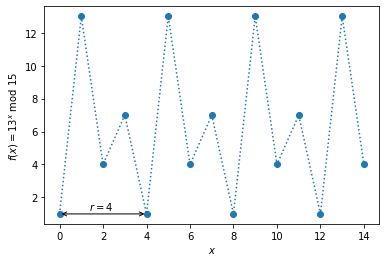

In [ ]:
N = 15; a = 13

x = [i for i in range(N)]
y = list(map(lambda n: fastExp(a, n, N), x))

r = 4
             
plt.plot(x, y, linestyle='dotted', marker='o')
plt.xlabel("$x$")
plt.ylabel("$f(x) = 13^x$ mod $15$")
plt.annotate(text='$r=4$', xy=(r/3, 1.2))
plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))

## Lagrange's Theorem

Let $H$ be a subgroup of $G$ and elements $a, b \in G$. Then
$$
\begin{align*}
    1. &\quad  a \in aH\\
    2. &\quad  aH = H \text{ if and only if } a \in H\\
    3. &\quad aH = bH \text{ if and only if } a \in bH\\
    4. &\quad aH = bH \text{ or } aH \cap bH = \emptyset 
\end{align*}
$$

If $G$ is finite group and $H \leqslant G$, then $|H|$ divides $|G|$. Moreover, the number of distinct left/right cosets of $H$ in $G$ is given by $|G|/|H|$.  


 Let $a_1 H, ..., a_d H$ be distinct left cosets of $H$ in $G$. Then, by Lemma 1, they are disjoint and
 
$$
    G = a_1H \cup \dots \cup a_dH
$$

And moreover,
$$
\begin{align*}
    |G| &= |a_1H| + \dots + |a_kH|\\
        &= d|H|
\end{align*}
$$

## Fermat's Little Theorem

An important result for the purposes of this notebook is Fermat's Little Theorem, which states the following

$$
    a^{p-1} \equiv 1 \text{ mod } p
$$

where $p$ is a prime and $0 \leq a \leq p - 1$.

We can prove this by reconizing that $\mathbb{Z}_p$ generates a group under multiplication modulo $p$, $G = \{1, 2, ..., p - 1\}$. Now let $d$ be the order of an element $a$, i.e, $d$ is the smallest positive integer such that $a^d \equiv 1 \text{ mod } p$, and it follows that the numbers $1, a, a^2, ..., a^{d - 1}$ are a subgroup of order $d$ of $G$.

Then it follows by Lagrange's Theorem that $d | p - 1$, and $p - 1 = dm$ for some m integer $m \geq 0$.

$$
    a^{p-1} \equiv a^{dm} \equiv (a^d)^m \equiv 1^m \equiv 1 \text{ mod } p
$$

And our result holds.

## Euler's Theorem

Now we can prove a generalization of Fermat's Little Theorem which states that 

$$
    a^{\phi(n)} \equiv 1 \text{ mod } n
$$

where $n$ is a positive integer and $\gcd(a, n) = 1$.

Again, by reconizing that $\mathbb{Z}_n$ with multiplicative inverses generates a group under multiplication modulo $n$, $G = \{1, 2, ..., \phi(n)\}$. The subgroup generated by an element $a$ of order $d$ consisted by the elements $1, a, a^2, ..., a^{d-1}$, and since $a^d \equiv 1 \text{ mod } n$, by Lagrange's Theorem we have that $d | \phi(n)$, and $\phi(n) = dm$ for some m integer $m \geq 0$.

$$
    a^{\phi(n)} \equiv a^{dm} \equiv (a^d)^m \equiv 1^m \equiv 1 \text { mod } n
$$

Hence our result holds.

# A (Qu)bit of Quantum Computation

In Classical Computers, those that some of us have at home, works under fundamental information unit of $0$'s and $1$'s bits, physically represented by low and high voltages on chips transistors. 

Differently Quantum Computers works under a basic unit of quantum information call qubits, represented on the computational basis $|0\rangle$ and $|1\rangle$.

$$
|0\rangle = \begin{bmatrix}
    1 \\
    0 
\end{bmatrix}  \quad
|1\rangle = \begin{bmatrix}
    0 \\
    1 
\end{bmatrix}
$$

We can physically interpretate qubits as hydrogen molecules, where the ground state is represented as the state $|0\rangle$ and the excited as the state $|1\rangle$.

A qubit can be mathematically represented as a linear combination

$$
    |\psi\rangle = \alpha|0\rangle + \beta|1\rangle
$$

with $\alpha$, $\beta \in \mathbb{C}$ and $|\alpha|^2 + |\beta|^2 = 1$.

In [ ]:
#define a 1 qubit state |0>
sv_0 = Statevector.from_label('0')
print('State_0  |x> = ', sv_0.data)

#define a 1 qubit state |1>
sv_1 = Statevector.from_label('1')
print('State_1  |x> = ', sv_1.data)

State_0  |x> =  [1.+0.j 0.+0.j]
State_1  |x> =  [0.+0.j 1.+0.j]


Quantum Mechanical Phenomena as superposition and entanglement can be used to create efficient problem solutions. And we do that by applying linear unitary transformations on quantum states.

One of the most important gates in Quantum Computing is the Hadarmad Gate $H$, a recursevely constructed matrix of order $2^n$.

$$
\begin{align*}
H_0 = \begin{bmatrix}
                       1
                       \end{bmatrix} \qquad
H_1 = \frac{1}{\sqrt{2}} \begin{bmatrix}
                       1 & 1\\
                       1 & -1
                       \end{bmatrix} \qquad 
H_n = \frac{1}{\sqrt{2^n}} \begin{bmatrix}
                       H_{n-1} & H_{n-1}\\
                       H_{n-1} & -H_{n-1}
                       \end{bmatrix}
\end{align*}
$$

Which can be used to put a state $|\psi\rangle$ in superposition, i.e, to take a state from the computational basis to the $|+\rangle$ and $|-\rangle$ basis, where we have $\frac{1}{2}$ probability of measuring $|1\rangle$ and $\frac{1}{2}$ of measuring $|0\rangle$. And we define the operation of applying a Hadarmard gate into a quantum state as it follows. Here we're going to assume $H = H_1$

$$
\begin{align*}
\\H|0\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix}
                                   1 & 1\\
                                   1 & -1
                                \end{bmatrix} 
                                %
             \begin{bmatrix}
             1 \\
             0
             \end{bmatrix}
             =
             \frac{|0\rangle + |1\rangle}{\sqrt{2}}
             =
             |+\rangle
\\\\H|1\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix}
                                   1 & 1\\
                                   1 & -1
                                \end{bmatrix} 
                                %
             \begin{bmatrix}
             0 \\
             1
             \end{bmatrix}
             =
             \frac{|0\rangle - |1\rangle}{\sqrt{2}}
             =
             |-\rangle
\end{align*}\\
$$

Which can be generally seen for an arbitrary state on n-qubits $|x\rangle$ as

$$
\begin{align*}
H|x\rangle &= \frac{1}{\sqrt{2^n}}\sum_{k \in \{0, 1\}^n}(-1)^{\langle x, k\rangle}|k\rangle
\end{align*}
$$

State_0 H|x> =  [0.70710678+0.j 0.70710678+0.j]


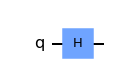

In [ ]:
#build a circuit with the H gate
mycircuit = QuantumCircuit(1)
mycircuit.h(0)

#apply the circuit into |x>
sv_0 = sv_0.evolve(mycircuit)

print('State_0 H|x> = ', sv_0.data)
mycircuit.draw('mpl')

### A Tensor Disclaimer

Given two matrices,

$$
    A = \begin{bmatrix}
    a_{00} & a_{01} \\
    a_{10} & a_{11} 
    \end{bmatrix}  \quad 
    B = \begin{bmatrix}
    b_{00} & b_{01} \\
    b_{10} & b_{11} 
    \end{bmatrix} 
$$

we define the kronecker (tensor) product of $A \otimes B$ as

$$
    A \otimes B =  \begin{bmatrix}
a_{00} B & a_{01} B \\
a_{10} B & a_{11} B 
\end{bmatrix}  
$$

Some useful examples and notation for qubit strings

$$
\begin{align*}
        |0\rangle_0 \otimes |0\rangle_1 \otimes \dots \otimes |0\rangle_n & = |00 \dots 0 \rangle \\ & =|0\rangle^{\otimes n}\\
\end{align*}
$$

Which is a vector of dimension $2^{n}$.

Analagously for matrices,

$$
\begin{align*}
    H \otimes H \otimes \dots \otimes H = H^{\otimes n}
\end{align*}
$$

Which is a matrix of dimensions $2^{n} \times 2^{n}$.

# Shor's Algorithm

On the beggining of this article we saw why factoring is such a difficult problem, and now we are going to introduce an algorithm that solves this problem efficiently. However, there's a catch, of course: this algorithm needs a quantum computer to execute it.

Invented by the MIT mathematician Peter Shor in 1994, Shor's algorithm is polinomyal-time quantum computer algorithm that solves the problem of integer factorization. In other words, the problem lies in the idea of: Given a integer $N$, such that $N = pq$, where $p$ and $q$ are large prime numbers, our goal is to find these factors efficiently. 

Classically as we have already discussed this problem would take an exponential amount of time to run in terms of the input lenght. While the quantum solution that we're going to discuss has a time complexity of the order of $O(N^3\log_2 N)$, where $N$ is the number of qubits, which can be even faster with proper optimizations. Therefore, we have an exponential speed-up when compared with classical solutions with the most clever known sub-exponential running time complexity of $O(e^{1.9(N^{1/3})(\log N)^{2/3}})$.

<img src="images/shor_circuit.png" style="width:1000px; height:180px"/>

## Setting up periodicity

The algorithm lies on the idea of finding a non-trivial square root of 1 modulo $N$, where $N$ is the integer that we want to factorize. To find such root we will compute the order of a given element $1 \leq a \leq N - 1$ modulo N. Which will be precisely given by the period of the periodic function $f(x) = a^{x} \text{ mod } N$ on the superposition created on $M$ qubits, where $M$ is a power of two $M \approx N$. 

Let's take our periodic function $f(x) = x^a\text{ mod }M$ and apply it to our algorithm input.

Initially we will initialilize two quantum registers with $|0\rangle^{\log M}|0\rangle^{N}$, and apply Hadamard gates on each of the $\log M$ first ones, to get a uniform superposition of the states from $0$ to $M - 1$.

$$
    H^{\otimes M}|0\rangle^{\log M}|0\rangle^{N} = \frac{1}{\sqrt{M}} \sum_{x = 0}^{M - 1} |x\rangle |0\rangle
$$

Now applying the periodic function $f(x)$ on the second register we will get an state

$$
    \frac{1}{\sqrt{M}} \sum_{x = 0}^{M - 1} |x\rangle |f(x)\rangle
$$

Then by measuring the second register we will get a periodic superposition on the first register of period $r$, which more precisely is the order of $a$.

The idea of why this happens is due the periodicity of our superposition, every *rth* position of the second register are the same, hence the measurement of the second register yelds a $y$ output between $0$ and $r - 1$. And the first register is now on superposition of only this values $y, y + r, \dots, y + M - r$, which is a periodic superpostion, with period $r$.

## The Quantum Period Finding Function

Finally, this period can be found by applying the Fast Fourier Transform, ops, the Quantum Fourier Transform :D 

The Fast Fourier Tranform can be seen as a transformation which takes our superposition on the computational basis and rotates it to the fourier basis.  For a input of size $M$ we have such as.

<img src="images/fourier_matrix.png" style="width:290px; height:160px"/>

Effectvely the QFT is just a change of basis from the Computational Basis to the Fourier Basis, one small example that we already know is given by the function $f$ that takes a single qubit 

$$
      f:\{|0\rangle, |1\rangle\} \rightarrow \{|+\rangle, |-\rangle\} 
$$

which is clearly done by the Hadarmard gate $H$, a single qubit QFT. Therefore, to the general case on state of $n$ qubits $|x\rangle$ we define the QFT as follows

$$
    |\chi\rangle = QFT|x\rangle = \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}e^{\frac{2\pi i xy}{N}}|y\rangle
$$

Hence, from that definition we can extract our single-qubit $\{|0\rangle, |1\rangle\}$ example, so let $N = 2$

$$
\begin{align*}
    QFT|x\rangle &= \frac{1}{\sqrt{2}}\sum_{y = 0}^{N-1}e^{\frac{2\pi ixy}{2}}|y\rangle\\
                 &= \frac{1}{\sqrt{2}}\bigg[e^{i\pi x0}|0\rangle + e^{i\pi x1}|1\rangle\bigg]\\
                 &= \frac{1}{\sqrt{2}}\bigg[|0\rangle + e^{i\pi x}|1\rangle\bigg]\\                    
                 &= \begin{cases} |+\rangle, & \mbox{if } |x\rangle = |0\rangle\\ |-\rangle, & \mbox{if } |x\rangle = |1\rangle \end{cases}\\
\end{align*}
$$

Now, expanding this from the general definition above on $n$ qubits we have that

$$
\begin{align*}
    |\chi\rangle &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}e^{\frac{2\pi i xy}{N}}|y\rangle\\
                 &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}e^{2\pi ix\sum_{k = 1}^{n}\frac{y^k}{2^k}}|y_1 y_2 \dots y_n\rangle\\
                 &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}\displaystyle\prod_{k = 1}^{n}e^{2\pi ix\frac{y^k}{2^k}}|y_1 y_2 \dots y_n\rangle\\                    
                 &= \frac{1}{\sqrt{N}}\bigotimes_{k = 1}^{n}\bigg(|0\rangle + e^{{\frac{2\pi ix}{2^k}}}|1\rangle\bigg)\\
                 &= \frac{1}{\sqrt{N}}\bigg(|0\rangle + e^{{\frac{2\pi ix}{2^1}}}|1\rangle\bigg)\otimes\bigg(|0\rangle + e^{{\frac{2\pi ix}{2^2}}}|1\rangle\bigg)\otimes\dots\otimes\bigg(|0\rangle + e^{{\frac{2\pi ix}{2^{n}}}}|1\rangle\bigg)
\end{align*}
$$

This represents a huge improvement on computational parameters, since classically this fuction presents a time complexity of the order $\mathcal{O}(M \log M)$ while quantum its quantum analogue $\mathcal{O}(\log^2 M)$, i.e, an exponential speed-up. This becomes clear when we observe that to encode all $M$ values from $0$ to $M-1$ we just need $\log M$ qubits.

And we can use this function to extract the period $r$ of a periodic superposition. We're not get in details of how to extract the period precisely, but thinking about a function that applies a certain periodic rotation on a string of qubits, what would happen if we applie it's inverse?

## The Protocol

Finally, with these concepts in hand we are able to see,  or almost, how the algorithm protocol works, with classical and quantum sub-routines. Let the input $N$ be an odd composite integer $N$.

**Step 1.** Randomly pick a number $a$, so that, $1 < a \leq N-1$. And choose $M$ to be a power of two close to $N$.

**Step 2.** Check if $a$ is a non-trivial factor of $N$, i.e, $\gcd(a, N) \neq 1$. If it is, then we got our answer and are good to go.

**Step 3.** Otherwise, initialize two registers with approximately $A \approx \log M$ and $B \approx \log N$ qubits (large enough to store modulo $M$ and $N$ values).

$$
   |q_0\rangle = |0\rangle^{A}|0\rangle^{B}
$$

Then apply hadamard gates on the first register, obtaining

$$
\begin{align*}
  |q_1\rangle & = H^{\otimes A}|0\rangle^{A}|0\rangle^{B}\\&= \frac{1}{\sqrt{M}} \sum_{x = 0}^{M - 1} |x\rangle |0\rangle
\end{align*}
$$


**Step 4.** Now, apply the periodic function $U_f = f(x) \equiv a^{x}\text{ mod }N$ to get the state

$$
\begin{align*}
    |q_2\rangle &= U_f |q_1\rangle\\
                &= \frac{1}{\sqrt{M}} \sum_{x = 0}^{M - 1} |x\rangle |a^{x}\text{ mod }N\rangle
\end{align*}
$$

Measuring the second register we get a superposition on the first register which contains the periodic superpostion desired

$$
\begin{align*}
    |q_3\rangle = \sqrt{\frac{r}{M}} \sum_{s = 0}^{\frac{M}{r - 1}} |sr + k\rangle 
\end{align*}
$$

where $k$ is number between $0$ and $r - 1$.

**Step 5.** Applying the inverse QFT (by Quantum Phase Estimation) we can extract the phase of our superposition and get the period $r$.

**Step 6.** Now if $r$ is a even number we can compute the $\gcd(N, r \pm 1)$ and if it is a not non-trivial factor of $N$ go back to **step 1**.

## Why this works?

The above results recurs from to lemmas, about non-trivial squaare roots. A non-trivial square root of $1$ modulo $N$ is any integer such that $x^2 \equiv 1 \text{ mod } N$ and $x^2 \equiv \pm 1 \text{ mod } N$.

**Lemma 1** *If* $x$ *is a non-trivial square root of* $1$ *modulo* $N$*, then one of* $\gcd(x \pm 1, N)$ *is a non-trivial factor of* $N$.


*Proof:*  $x^2 \equiv 1 \text{ mod } N$ implies that $N | (x^2 - 1) = (x+1)(x-1)$. But since $x \ncong \pm 1 \text{ mod } N$, $N$ does not divide either of the individual terms. Therefore one of $\gcd(x \pm 1, N)$ is a non-trivial factor of $N$.

**Lemma 2** *Let $p, q$ be primes and $N = pq$, and* $x$ *be an uniformly chosen number between* $0$ *and* $N-1$. *If* $\gcd(x, N) = 1$*, then with probability at least* $\frac{3}{8}$ *the order* $r$ *of* $x \text{ mod } N$ *is even, and moreover* $x^{r/2}$ *is a non-trivial square of* $1 \text{ mod } N$.

*Proof:* To prove this we can use the Chinese Remainder Theorem. Lets choose a number $x$ uniformly between $0$ and $N - 1$. Which is the same of choosing $x_i$ and $x_j$ from $0$ to $p-1$ and $0$ to $q-1$ respectvely. And moreover we have that $r_i | r$ and $r_j | r$, the orders of $x_i$ and $x_j$ respectively.

Hence, $r_i$ is even when $x_i$ is odd and $r_j$ is even when $x_j$ is odd. Then, as $r$ is even when $r_i$ or $r_j$ is even, therefore $r$ is even with probability $3/4$.

Now, we need to show that the probability of $x^{\frac{r}{2}} \equiv \pm 1 \text{ mod } N$ is at most $1/2$ when $r$ is even. As $x^{r} \equiv 1 \text{ mod } p$ and $x^{r} \equiv \text{ mod } q$ and there are only two square roots of 1 modulo a prime number, $\pm 1$. There only four roots of $1$ modulo $N$, where only two of them can make  $x^{\frac{r}{2}} \equiv \pm 1 \text{ mod } N$.

Further we conclude that our result holds.

## References 

__[Wikipedia | Shor's Algorithm](https://en.wikipedia.org/wiki/Shor%27s_algorithm)__\
__[Learn Quantum Computation using Qiskit](https://qiskit.org/textbook/ch-algorithms/shor.html)__\
__[Algorithms - Dasgupta, C. H. Papadimitriou, and U. V. Vazirani]()__